# Random variables to random vectors to random functions

In this lesson we'll progress through random variables to random vectors to random functions.  We'll find at the end that we've fit our first GP!

## Random variables

You've already learned about random variables, so we won't dwell on this step.  Below we draw 10k samples from a normal random variable.

In [1]:
import arviz as az
import aesara.tensor as at
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

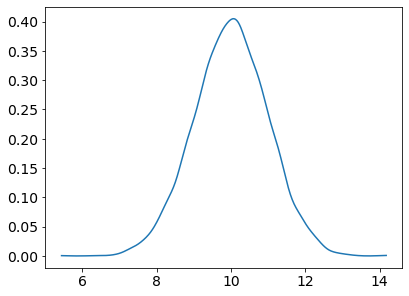

In [2]:
theta = pm.draw(pm.Normal.dist(mu=10, sigma=1), 10_000)

az.plot_dist(theta);

# Now let's generalize to random vectors

In this first example, the distinction between random vector and random variable is just semantic.  A random vector at it's simplest is just random variables stuck together.  

In [3]:
# Make three random variables, put them into a vector
theta1 = pm.Normal.dist(mu=4, sigma=1)
theta2 = pm.Normal.dist(mu=2, sigma=2)
theta3 = pm.Normal.dist(mu=6, sigma=0.5)

# Stick the three random variables together into a random vector
random_vector = [theta1, theta2, theta3]

# Draw samples from the random vector
samples = pm.draw(at.as_tensor_variable(random_vector), draws=10_000)
print("Shape of samples:", samples.shape)

Shape of samples: (10000, 3)


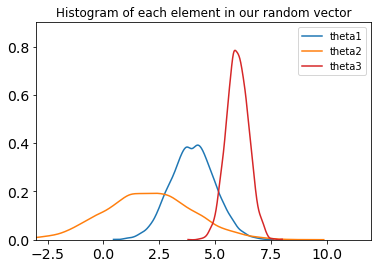

In [4]:
colors = ["C0", "C1", "C3"]

for i in range(3):
    az.plot_dist(samples[:, i], color=colors[i], label="theta" + str(i+1))

plt.title("Histogram of each element in our random vector");
plt.xlim([-3, 12]);
plt.ylim([0.0, 0.9]);

The last example is a trivial case because there is no relationship between the three random variables.  To become a random vector, all we did was stick them together into a list and start thinking about them as something that works together as one "unit".  Usually though, there's not much of a point of talking about random vectors when their random variables have no relationship.  

### Multivariate normals

The most important type of random vector for this course is the multivariate normal.  Let's recreate the random vector above, but this time with a multivariate normal.  Notice that `np.diag` makes `C` a diagonal matrix, with the listed elements going top to bottom from left to right down the diagonal. 

In [5]:
mu = [4, 2, 6]
C = np.diag([1, 2, 0.5])

random_vector = pm.MvNormal.dist(mu=mu, cov=C)

samples = pm.draw(random_vector, draws=10_000)

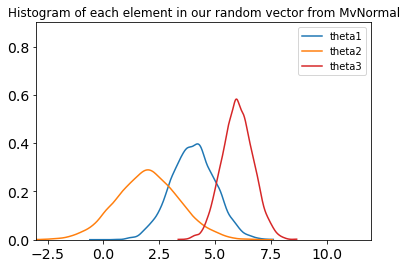

In [6]:
colors = ["C0", "C1", "C3"]

for i in range(3):
    az.plot_dist(samples[:, i], color=colors[i], label="theta" + str(i+1))

plt.title("Histogram of each element in our random vector from MvNormal");
plt.xlim([-3, 12]);
plt.ylim([0.0, 0.9]);

Other than the randomness from the random number generator, this and the independent normals are the same.  Let's start plotting this in a different way now.  What if this was a short, 3 data point time series?  We'd plot it like this:

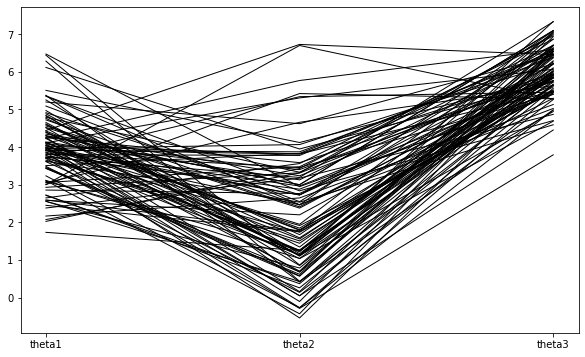

In [7]:
mean_ts = np.mean(samples, axis=0)
sigma_ts = np.std(samples, axis=0)

t = np.arange(3)
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 100)
ax.plot(t, samples[ix, :].T, color="k", lw=1.0)

ax.set_xticks(t)
ax.set_xticklabels(["theta1", "theta2", "theta3"]);

So this is another way of viewing a three dimensional dataset. If we plot things all in row like this, we can plot any number of dimensions.  However, plotting it this way does end up obscuring the relationships, or correlations, between dimensions though.  Nothing comes for free!

Let's draw this out and plot samples from a 10 dimensional normal.  To make it a bit simpler, we'll give them all the same variance for now (though this doesn't have to be the case!).  We'll also set the mean to zero.

In [8]:
mu = np.zeros(10)
C = np.diag(np.ones(10))

random_vector = pm.MvNormal.dist(mu=mu, cov=C)

samples = pm.draw(random_vector, draws=10_000)

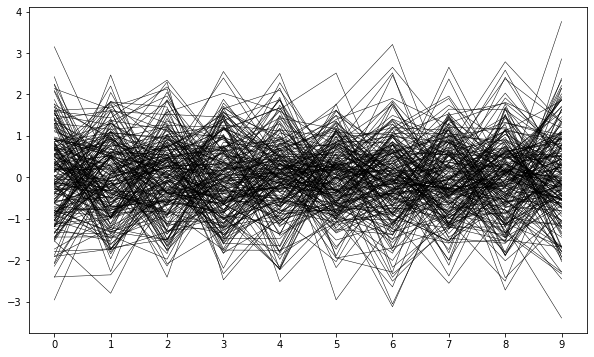

In [9]:
t = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 200)
ax.plot(t, samples[ix, :].T, color="k", lw=0.5)

ax.set_xticks(t);

You can see that there's no real relation here, so plotting using lines instead of dots is potentially misleading.  Let's make a random variable though where there are relationships between different random variables.

## Remember kernels?

What if we used a kernel as the covariance matrix of a multivariate normal?  Remember the main takeaway from that lesson, kernel functions give the similarity of the points in $y$, depending on the points $x$ and $x'$.  *Isn't this kind of the same thing as the covariances bwetween elements in a multivariate normal?*  

Let's try it out.  Let's take our same exponentiated quadratic kernel from Art class, use it to calculate a 10 by 10 covariance matrix, and use it to draw samples from a multivariate normal.  

In [10]:
# Copy/paste our kernel function from the art class lesson
def kernel(x, x_prime, lengthscale):
    return np.exp( -0.5 * np.square(x - x_prime) / np.square(lengthscale))

# Calculate kernel/covariance matrix values for every possible pair of x values in the data
K = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        K[i, j] = kernel(t[i], t[j], lengthscale=2)
        
# Lets use a zero mean this time
mu = np.zeros(10)
    
# Draw samples from this random vector
random_vector = pm.MvNormal.dist(mu=mu, cov=K)
samples = pm.draw(random_vector, draws=10_000)

This is our first example of a random vector where there are relationships between the different X's.  And of course, these relationships are determined by the kernel matrix.  

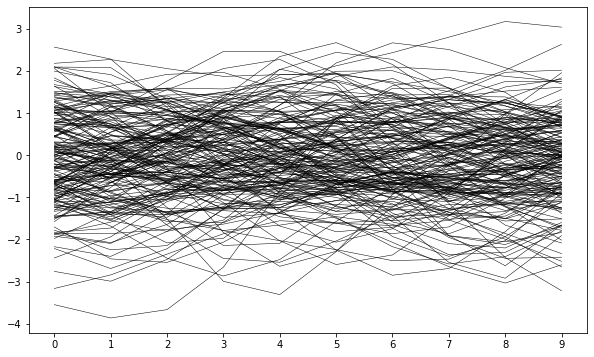

In [11]:
t = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 200)
ax.plot(t, samples[ix, :].T, color="k", lw=0.5)

ax.set_xticks(t);

## ... so can we use this distribution as a prior?

Yes!  We certainly can.  There's no reason priors have to be one dimensional.  Let's make some fake data and try it out.  Here's our example dataset.  It's count data (that I'm making up).  It start's low and then goes a bit higher, if you go left to right.  Poisson distributions are parameterized by a rate parameter.  By eyeballing this data, we might suspect that the rate is changing over time.  First the rate is low, maybe 0.5 or 1 events per second.  Then on the right, its higher.  Maybe 4 or 5 events per second.  We don't know if there was an abrupt change, or if the rate gradually increases over time, which is why we won't just fit two rate parameters (which would be repesented by two random variables).  By eye, it at least looks like it should change "smoothly" from left to right.  It does not look like there is evidence in the data to suggest that the rate jumps around all over the place.

Let's fit three models.

1. A length 15 multivariate normal prior on rate. This is the MvNormal with the constant diagonal covariance example above.  Yes, models 1 and 2 are the same (Exercise: fit a model with 15 IID normals, instead of a multivariate normal with diagonal covariance.  verify this is the same)
2. A multivariate normal prior with a kernel for the covariance matrix.

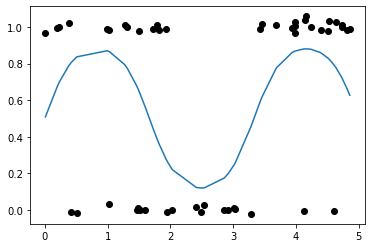

In [14]:
x = 5 * np.sort(np.random.rand(50))
p = at.sigmoid( 2 * np.sin(2 * np.pi * x * 0.3) ).eval()
y = np.random.binomial(1, p=p)

jitter = 0.02 * np.random.randn(len(x))
plt.plot(x, y + jitter, "ok");
plt.plot(x, p);

In [15]:
import pymc.sampling_jax

/Users/andre/miniconda3/envs/dev/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [16]:
## model 1
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=1)
   
    # A multivariate normal random vector prior, with no correlation between elements
    mu = np.zeros(N)
    cov = eta**2 * np.diag(np.ones(N))
    f = pm.MvNormal("f", mu=mu, cov=cov)
    
    p = at.sigmoid(f)
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)
    
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Compiling...
Compilation time =  0:00:01.484789
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:15.434927
Transforming variables...
Transformation time =  0:00:00.027521
Computing Log Likelihood...
Log Likelihood time =  0:00:00.819444


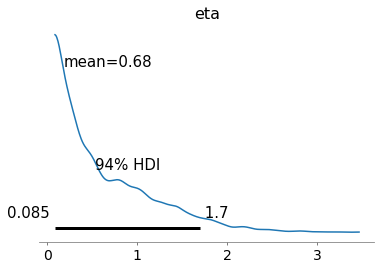

In [17]:
az.plot_posterior(idata, var_names=['eta']);

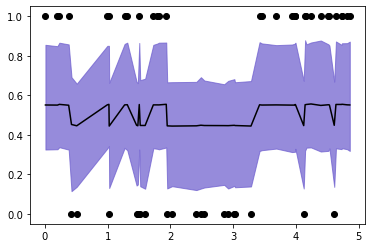

In [18]:
f = idata.posterior.f.stack(samples=['chain', 'draw']).values
p = at.sigmoid(f).eval()

plt.fill_between(x, np.percentile(p, 5, axis=1), np.percentile(p, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, np.mean(p, axis=1), color="k");
plt.plot(x, y, "ok");

We can see that these results look somewhat reasonable!  The rate parameter starts low, and then gets larger, which follows our intuition about the data pretty well.  We can also see that it varies pretty widely too.  What I mean is, it's not "smooth" as we move left to right.  

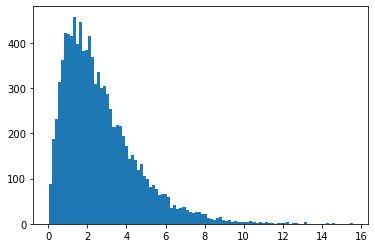

In [26]:
plt.hist(pm.draw(pm.Gamma.dist(alpha=2, beta=0.75), 10000), 100);

In [39]:
## model 2
N = len(x) # number of data points
with pm.Model() as model:
    
    # scale the variance of the prior
    eta = pm.HalfNormal("eta", sigma=10)
   

    # A multivariate normal random vector prior, with correlation between the inputs
    # We're using the pm.gp.cov.ExpQuad function in PyMC, which implements the same 
    # code that we wrote earlier in our function called "kernel"
    mu = np.zeros(N)
    lengthscale = pm.Gamma("lengthscale", alpha=2, beta=0.75)
    #lengthscale = 4
    #eta = 1.0
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
    
    #gp = pm.gp.Latent(cov_func=cov_func)
    #f = gp.prior('f', X=x[:, None])
    
    cov = cov_func(x[:, None])
    f = pm.MvNormal("f", mu=mu, cov=cov)
    
    p = pm.math.sigmoid(f)
    lik = pm.Bernoulli("lik", p=p, observed=y)

with model:
    idata = pm.sample(init='jitter+adapt_full', target_accept=0.9)
    #idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.9)
    
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'eta_log__': array(1.98156816), 'lengthscale_log__': array(1.60097873), 'f': array([-0.67641894,  0.17994353, -0.95361695,  0.36422864,  0.36602527,
       -0.44574168, -0.16940867, -0.59780865, -0.02131116, -0.99669594,
        0.59321196, -0.80730007,  0.39517363,  0.04034202, -0.726204  ,
        0.05566003, -0.07873009, -0.47056187,  0.64717892,  0.59499476,
       -0.13494246,  0.62357315,  0.62945553, -0.29999174, -0.2325169 ,
        0.21273951,  0.12959517, -0.67573644,  0.27870814,  0.14477499,
       -0.38328969, -0.95314768,  0.45220535,  0.84422791,  0.8464493 ,
        0.60526923,  0.43257641,  0.40978953,  0.33227321,  0.30200207,
        0.70201859,  0.31947149, -0.09205092, -0.85152057, -0.94997783,
       -0.36395544,  0.84094688,  0.67872465,  0.0070627 ,  0.54323914])}

Initial evaluation results:
{'eta': -0.81, 'lengthscale': -1.09, 'f': -inf, 'lik': -34.59}

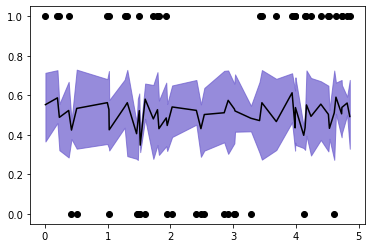

In [28]:
f = idata.posterior.f.stack(samples=['chain', 'draw']).values
mu = at.sigmoid(f).eval()

plt.fill_between(x, np.percentile(mu, 5, axis=1), np.percentile(mu, 95, axis=1), edgecolor="k", color="slateblue", alpha=0.7)
plt.plot(x, np.mean(mu, axis=1), color="k");
plt.plot(x, y, "ok");

Notice that we didnt put a prior on the lengthscale -- that's a whole "deal", so we'll return to it later.  For now, 

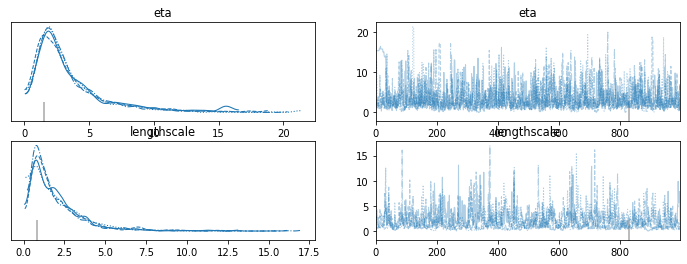

In [22]:
az.plot_trace(idata, var_names=["eta", "lengthscale"]);

In [31]:
pm.init_nuts?

Signature:
pm.init_nuts(
    *,
    init: str = 'auto',
    chains: int = 1,
    n_init: int = 500000,
    model=None,
    random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType] = None,
    progressbar=True,
    jitter_max_retries: int = 10,
    tune: Optional[int] = None,
    initvals: Union[Dict[Union[aesara.graph.basic.Variable, str], Union[numpy.ndarray, aesara.graph.basic.Variable, str]], Sequence[Optional[Dict[Union[aesara.graph.basic.Variable, str], Union[numpy.ndarray, aesara.graph.basic.Variable, str]]]], NoneType] = None,
    **kwargs,
) -> Tuple[Sequence[Dict[str, numpy.ndarray]], pymc.step_methods.hmc.nuts.NUTS]
Docstring:
Set up the mass matrix initialization for NUTS.

NUTS convergence and sampling speed is extremely dependent on the
choice of mass/scaling matrix. This function implements different
methods for choosing or adapting the mass matrix.

Parameters
----------
init : str
    Initialization method to use.

    * auto: Choose a default initialization meth